# Download data

In [ ]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 
!unzip -q Positive_tensors.zip 
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip 
!unzip -q Negative_tensors.zip 

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
import time
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from torch import optim 
torch.manual_seed(0)

In [2]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        
        directory = '/home/dsxuser/work'
        positive = "Positive_tensors"
        negative = "Negative_tensors"

        positive_file_path = os.path.join(directory, positive)
        negative_file_path = os.path.join(directory, negative)
        positive_files = [os.path.join(positive_file_path, file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files = [os.path.join(negative_file_path, file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        
        number_of_samples = len(positive_files)+len(negative_files)
        
        self.all_files = [None]*number_of_samples
        self.all_files[::2] = positive_files
        self.all_files[1::2] = negative_files 
        
        # The transform is goint to be used on image
        self.transform = transform
        
        #torch.LongTensor
        self.Y = torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2] = 1
        self.Y[1::2] = 0
        
        NUM_OF_ITEMS_FOR_SPLITTING = 30000
        if train:
            self.all_files = self.all_files[:NUM_OF_ITEMS_FOR_SPLITTING]
            self.Y = self.Y[:NUM_OF_ITEMS_FOR_SPLITTING]
            self.len = len(self.all_files)
        else:
            self.all_files = self.all_files[NUM_OF_ITEMS_FOR_SPLITTING:]
            self.Y = self.Y[NUM_OF_ITEMS_FOR_SPLITTING:]
            self.len = len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):               
        image = torch.load(self.all_files[idx])
        y = self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)
        return image, y

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

composed = transforms.Compose([ transforms.Normalize(mean, std)])

train_dataset = Dataset(transform=composed,train=True)
validation_dataset = Dataset(transform=composed,train=False)

In [5]:
model = models.resnet18(pretrained=True)
device = torch.device("cpu")
model = model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
for param in model.parameters():
    param.requires_grad = False

In [7]:
fc_size = 512
output_size = 2
model.fc = nn.Linear(fc_size,output_size)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
criterion = nn.CrossEntropyLoss()

In [9]:
batch_size = 100

train_loader = DataLoader(train_dataset, batch_size=batch_size)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)

In [10]:
# Verify the parameters whose requires_grad are True
for param in model.parameters():
    if param.requires_grad:
        print(param)

Parameter containing:
tensor([[ 0.0342, -0.0255,  0.0249,  ...,  0.0130, -0.0365, -0.0426],
        [ 0.0411, -0.0204,  0.0384,  ...,  0.0156, -0.0340,  0.0069]],
       requires_grad=True)
Parameter containing:
tensor([0.0074, 0.0091], requires_grad=True)


In [11]:
optimizer = optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=1e-3)

In [12]:
n_epochs = 1
loss_list = []
accuracy_list = []
accuracy = 0
correct = 0
N_test = len(validation_dataset)
N_train = len(train_dataset)
start_time = time.time()
#n_epochs

print("Number of items in training set : ", N_train)
print("Number of items in testing set : ", N_test)

running_loss = 0
start_time = time.time()
for epoch in range(n_epochs):
    for i, (x, y) in enumerate(train_loader):        
        print('-' * 30)
        print('Iteration (train phase) {}/{}'.format(i+1, int(N_train/batch_size)))
        i_start_time = time.time()
        
        x = x.to(device)
        y = y.to(device)
            
        # set model to train 
        model.train() 
        
        # clear gradient 
        optimizer.zero_grad()
     
        # make a prediction 
        z = model(x)
   
        # calculate loss 
        loss = criterion(z, y) 
        # loss.requires_grad = True
    
        # calculate gradients of parameters 
        loss.backward()
        
        # update parameters 
        optimizer.step()
        
        loss_list.append(loss.data)
        print("Finished in {} (s)".format(time.time()-i_start_time))
    # end for
        
    correct=0
    for i, (x_test, y_test) in enumerate(validation_loader):
        print('-' * 30)
        print('Iteration (validation phase) {}/{}'.format(i+1, int(N_test/batch_size)))
        i_start_time = time.time()
        
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        
        # set model to eval 
        model.eval()
       
        # make a prediction 
        z = model(x_test)
        
        # find max 
        _, yhat = torch.max(z.data, 1)
       
       
        #Calculate misclassified  samples in mini-batch 
        #hint +=(yhat==y_test).sum().item()
        correct += (yhat==y_test).sum().item()  
        
        print("Finished in {} (s)".format(time.time()-i_start_time))
    # end for
    
    accuracy=correct/N_test
    print("Epoch %d - accuracy: %.3f" % (epoch+1, accuracy))
    
    accuracy_list.append(accuracy)
    print("-" * 72)
    
    # Save model
    model_file_path = model_path + "resnet18_trained_model_epoch_{}.pth".format(epoch+1)
    torch.save(model.state_dict(), model_file_path)
    
    # Duration for epoch
    print("Finished epoch {} in {} (s).".format(epoch+1, time.time()-start_time))

Number of items in training set :  30000
Number of items in testing set :  10000
------------------------------
Iteration (train phase) 1/300
Finished in 5.770737171173096 (s)
------------------------------
Iteration (train phase) 2/300
Finished in 5.292453050613403 (s)
------------------------------
Iteration (train phase) 3/300
Finished in 5.083674669265747 (s)
------------------------------
Iteration (train phase) 4/300
Finished in 5.124558925628662 (s)
------------------------------
Iteration (train phase) 5/300
Finished in 5.092546701431274 (s)
------------------------------
Iteration (train phase) 6/300
Finished in 5.097190856933594 (s)
------------------------------
Iteration (train phase) 7/300
Finished in 5.12989068031311 (s)
------------------------------
Iteration (train phase) 8/300
Finished in 5.081090450286865 (s)
------------------------------
Iteration (train phase) 9/300
Finished in 5.136621952056885 (s)
------------------------------
Iteration (train phase) 10/300
Fin

NameError: name 'model_path' is not defined

In [13]:
accuracy

0.9951

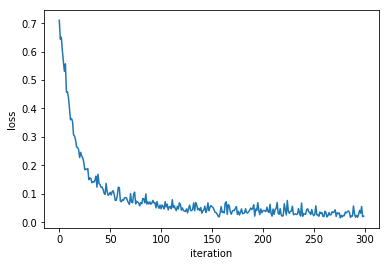

In [14]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

In [15]:
count = 0
max_num_of_items = 4  # first four mis-classified samples
validation_loader_batch_one = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1)

for i, (x_test, y_test) in enumerate(validation_loader_batch_one):
    # set model to eval
    model.eval()
    
    # make a prediction
    z = model(x_test)
    
    # find max
    _, yhat = torch.max(z.data, 1)
    
    # print mis-classified samples
    if yhat != y_test:
        print("Sample : {}; Expected Label: {}; Obtained Label: {}".format(str(i), str(y_test), str(yhat)))
        count += 1
        if count >= max_num_of_items:
            break
    # end if
# end for

Sample : 94; Expected Label: tensor([1]); Obtained Label: tensor([0])
Sample : 284; Expected Label: tensor([1]); Obtained Label: tensor([0])
Sample : 319; Expected Label: tensor([0]); Obtained Label: tensor([1])
Sample : 939; Expected Label: tensor([0]); Obtained Label: tensor([1])
